In [1]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.plugins import HeatMap

# import United National votings' datasets 
issues = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-23/issues.csv')
unvotes = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-23/unvotes.csv')
roll_calls = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-23/roll_calls.csv')

/Users/ngkokteng/PycharmProjects/Large-Scale Data Analysis and Visualization/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# merge datasets
merged = pd.merge(unvotes, roll_calls, on='rcid')
merged = pd.merge(merged, issues, on='rcid')
merged.drop(columns = ["country_code", "importantvote", "unres", "amend", "para", "short", "descr", "short_name", "issue"], inplace = True)
# define the score (value) for the voting status
vote_mapping = {'yes': 1, 'no': -1, 'abstain': 0}
# apply the mapping to the vote column
merged['vote'] = merged['vote'].map(vote_mapping)
# converting the date into datetime data type
merged['date'] = pd.to_datetime(merged['date'])
# extract only year value from date column
merged['year'] = merged['date'].dt.year
# using the group by function based on year and country then sem up their voting score within the grouped variable
grouped = merged.groupby(['year', 'country'])['vote'].sum().reset_index()
# using the pivot function to doing one-hot encoding based on the country and the value would be the vote value of the year
pivot = grouped.pivot(index='year', columns='country', values='vote')

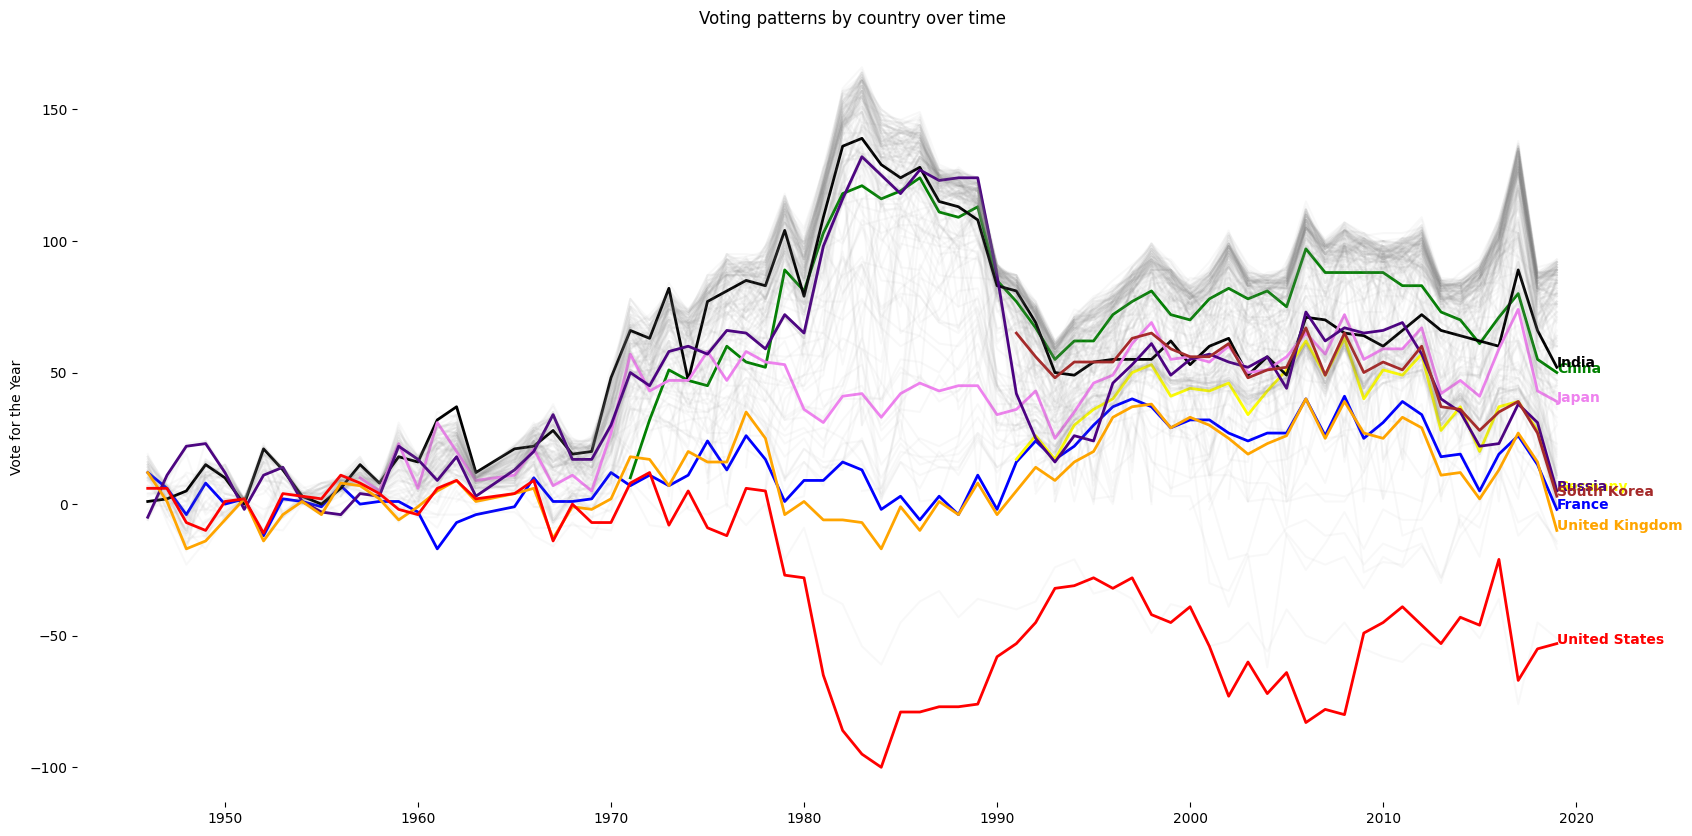

In [17]:
# define the list of countries to highlight (only focus on these countries visualization)
highlight_countries = ["United States", "United Kingdom", "Germany", "China", "France", "Russia", "Japan", "India", "South Korea"]
# define the colors for the highlighted countries
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black', "brown"]
# start to plot the data
fig, ax = plt.subplots(figsize=(20,10))
# loop through each country and plot a line
for country in pivot.columns:
    if country in highlight_countries:
        line, = ax.plot(pivot.index, pivot[country], label=country, linewidth=2, color=colors[highlight_countries.index(country)])
        ax.text(pivot.index[-1], pivot[country].values[-1], country, color=line.get_color(), weight='bold')  # ddd country name beside the line (not using legend to save data-ink and reduce chartjunk)
    else:
        ax.plot(pivot.index, pivot[country], color='gray', alpha=0.05)  # plot other countries in gray when it is not highlighted
ax.set_ylabel('Vote for the Year')
ax.set_title('Voting patterns by country over time')
# remove frame for saving data-ink
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()


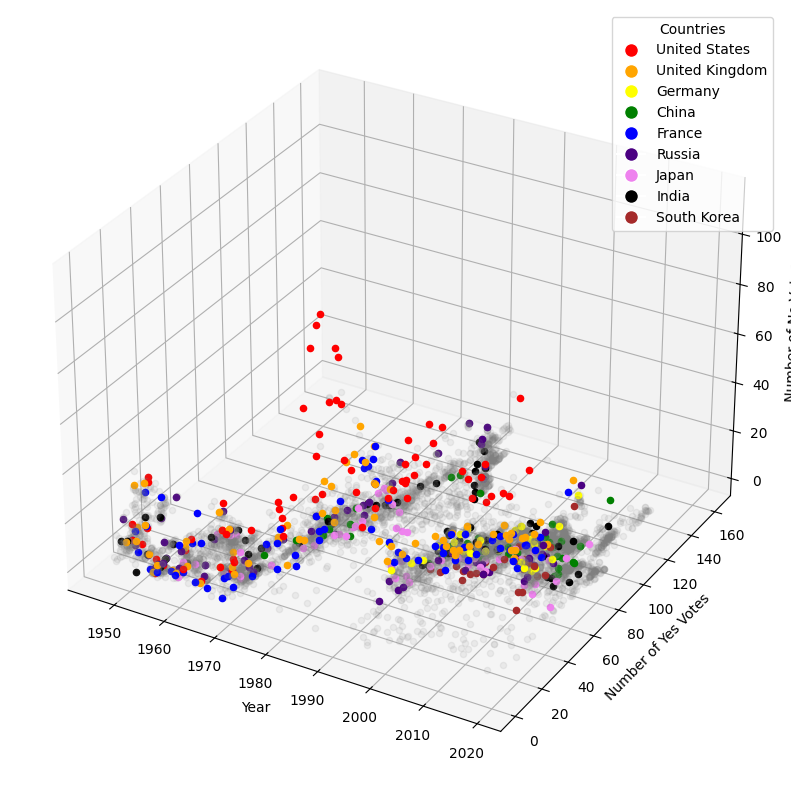

In [18]:
# merging datasets
merged = pd.merge(unvotes, roll_calls, on='rcid')
merged = pd.merge(merged, issues, on='rcid')
merged.drop(columns = ["country_code", "importantvote", "unres", "amend", "para", "short", "descr", "short_name", "issue"], inplace = True)

# define a mapping from vote strings to numbers
vote_mapping = {'yes': 1, 'no': -1, 'abstain': 0}
# apply the mapping to convert those vote state into certain value of the vote column
merged['vote'] = merged['vote'].map(vote_mapping)
# extract year from date column of datatime data type
merged['year'] = pd.to_datetime(merged['date']).dt.year

# calculate the number of 'yes' and 'no' votes for each country each year
grouped_yes = merged[merged['vote'] == 1].groupby(['year', 'country'])['vote'].count().reset_index()
grouped_no = merged[merged['vote'] == -1].groupby(['year', 'country'])['vote'].count().reset_index()

# merge the 'yes' and 'no' dataframes
grouped = pd.merge(grouped_yes, grouped_no, on=['year', 'country'], suffixes=('_yes', '_no'))

# define the list of countries to highlight
highlight_countries = ["United States", "United Kingdom", "Germany", "China", "France", "Russia", "Japan", "India", "South Korea"]
# define the colors for the highlighted countries
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black', "brown"]
# create a color map that maps each country to a color
color_map = {country: color for country, color in zip(highlight_countries, colors)}

# create 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# ddd data points to the plot
for i, row in grouped.iterrows():
    if row['country'] in highlight_countries:
        ax.scatter(row['year'], row['vote_yes'], row['vote_no'], color=color_map[row['country']], alpha=1.0, label=row['country'])
    else:
        ax.scatter(row['year'], row['vote_yes'], row['vote_no'], color='gray', alpha=0.05)

ax.set_title('Relationship between each country visualization based on voting status over year data')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Yes Votes')
ax.set_zlabel('Number of No Votes')

# create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[country], markersize=10) for country in highlight_countries]
ax.legend(handles, highlight_countries, title='Countries', loc='upper right')

plt.show()

In [4]:
# merging the unvotes and roll calls dataset
merged_data = pd.merge(unvotes, roll_calls, on = "rcid")
# import the external dataset that contains latitude and longitude for each country
country_code = pd.read_csv("countries_codes_and_coordinates.csv")
country_code = country_code[["Country", "Latitude (average)", "Longitude (average)"]]
# rename the column name for merging purpose
country_code = country_code.rename(columns = {"Country" : "country", "Latitude (average)" : "latitude", "Longitude (average)" : "longitude"})
# merging the longitude and latitude of each country into the merged dataset
merged_data = pd.merge(merged_data, country_code, on = "country")
# doing the trip to remove those extra symbols from longitude and latitude
merged_data['longitude'] = merged_data['longitude'].str.strip().str.strip('"')
merged_data['latitude'] = merged_data['latitude'].str.strip().str.strip('"')

# create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    merged_data, 
    geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude)
)

# representing how each countries voting
# create a map centered around the coordinates [0, 0]
m = folium.Map(location=[0, 0], zoom_start=2, tiles='https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png', attr='Stadia Maps')
# getting the latitude and longitude of each location
locations = gdf[['latitude', 'longitude']].values
# define the color gradient
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
# create a HeatMap and add it to the map
HeatMap(locations, gradient=gradient).add_to(m)
# save the map to an HTML file
m.save('heatmap.html')

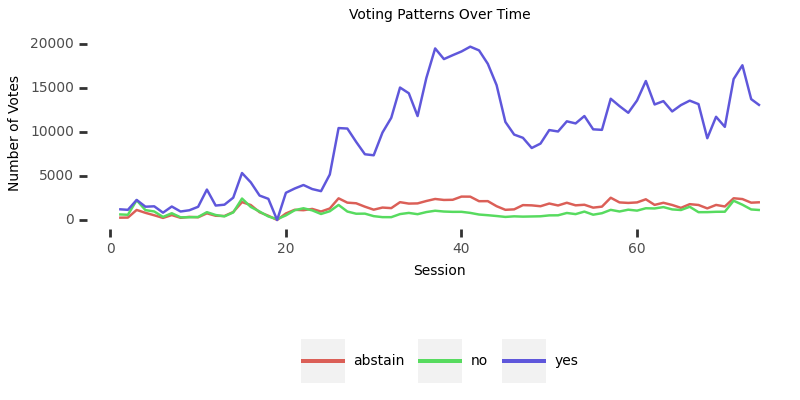

In [5]:
from plotnine import *

# Merge the datasets on 'rcid'
merged = pd.merge(roll_calls, unvotes, on='rcid')

# Group by 'session' and 'vote', and count the number of votes
grouped = merged.groupby(['session', 'vote']).size().reset_index(name='counts')

# Pivot the data to wide format for plotting
pivot_df = grouped.pivot(index='session', columns='vote', values='counts')

# Convert the wide format data to long format for plotting with plotnine
long_df = pivot_df.reset_index().melt(id_vars='session', var_name='vote', value_name='counts')

# Determine the start and end points for the x-axis
start = long_df['session'].min()
end = long_df['session'].max()

# Plot the data
(
    ggplot(long_df, aes(x = 'session', y = 'counts', color = 'vote'))
    + geom_line()
    + labs(x = 'Session', y = 'Number of Votes', title='Voting Patterns Over Time')
    + theme(figure_size = (4, 2),
            legend_position = 'bottom',
            plot_title = element_text(hjust=0.5, size=5),
            axis_title = element_text(size=5),
            axis_text = element_text(size=5),
            legend_text = element_text(size=5),
            plot_background = element_blank(),
            panel_background = element_rect(fill='white'),
            panel_grid = element_blank())
    + guides(color = guide_legend(title=""))
).draw()
